<a href="https://colab.research.google.com/github/Aleksandr62aa/Test_task/blob/main/FC_NN_diabetes_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of Diabetes**

**Dataset Diabetes**

**Importing libraries**

In [38]:
# requirements.txt

!pip install torchinfo
!pip install toml

**nodes**

In [39]:
# CustomDataset.py

import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, config, train=True, train_ratio=0.8):
        self.file_data = config["dataset"]["file_data"]
        self.train = train
        self.train_ratio = train_ratio
        self.load_data()

    def load_data(self):
        # read csv file
        data_frame = pd.read_csv(self.file_data)

        # Разделить данные на признаки и целевую переменную
        x_np = data_frame.iloc[:,:-1].values
        y_np = data_frame.iloc[:,-1].values

        # Applying StandardScaler
        scaler = StandardScaler()
        x_np_tran = scaler.fit_transform(x_np)

        # Разделить данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(
                                    x_np_tran, y_np, train_size=self.train_ratio, shuffle=False)

        if self.train:
            self.X = torch.tensor(X_train, dtype=torch.float32)
            self.y = torch.tensor(y_train, dtype=torch.int64)
        else:
            self.X = torch.tensor(X_test, dtype=torch.float32)
            self.y = torch.tensor(y_test, dtype=torch.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [40]:
# DiabedNet.py

class DiabedNet(torch.nn.Module):
    def __init__(self, config):
        # super().__init__()
        super(DiabedNet, self).__init__()
        input_size = config["model"]["input_size"]
        n_hidden_1 = config["model"]["n_hidden_1"]
        n_hidden_2 = config["model"]["n_hidden_2"]
        n_hidden_3 = config["model"]["n_hidden_3"]
        classes = config["model"]["classes"]
        self.fc1 = torch.nn.Linear(input_size, n_hidden_1)
        self.fc2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = torch.nn.Linear(n_hidden_2, n_hidden_3)
        self.fc4 = torch.nn.Linear(n_hidden_3, classes)
        self.relu = torch.nn.ReLU()
        # self.drop_out = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [41]:
# TrainingNN.py

class TrainingNN():
    def __init__(self, config, train_dataloader, test_dataloader):
        self.num_epochs = config["training"]["num_epochs"]
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.test_loss_history = []
        self.test_accuracy_history = []

    def training(self, model, loss, optimizer):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        for epoch in tqdm(range(self.num_epochs)):   # цикл обучения по эпохам
            running_loss_train = 0.
            running_acc_train = 0.
            model.train()

            for batch in self.train_dataloader:# цикл обучения по бачам
                optimizer.zero_grad()
                X_batch, y_batch = batch

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_preds = model.forward(X_batch)

                # loss функция
                loss_train = loss(y_preds, y_batch)

                loss_train.backward()
                optimizer.step()
                running_loss_train += loss_train.cpu().detach().numpy()
                running_acc_train += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()
            epoch_loss = running_loss_train/ len(self.train_dataloader)
            self.train_loss_history.append(epoch_loss)

            epoch_acc = running_acc_train/len(self.train_dataloader)
            self.train_accuracy_history.append(epoch_acc)

            # тестирование модели
            running_loss_test = 0.
            running_acc_test = 0.
            model.eval()

            for batch in self.test_dataloader:
                X_batch, y_batch = batch
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_preds = model.forward(X_batch)

                running_loss_test += loss(y_preds, y_batch).cpu().detach().numpy()
                running_acc_test += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()

            epoch_loss = running_loss_test/len(self.test_dataloader)
            self.test_loss_history.append(epoch_loss)

            epoch_acc = running_acc_test/len(self.test_dataloader)
            self.test_accuracy_history.append(epoch_acc)

    def get_history(self):
        return self.train_loss_history, self.train_accuracy_history, self.test_loss_history, self.test_accuracy_history

**utils_local**

In [42]:
# ClassificationMetrics.py

from sklearn.metrics import accuracy_score, classification_report

class ClassificationMetrics():
    def __init__(self, test_dataloader):
        self.test_dataloader = test_dataloader
        self.y_true = []
        self.y_pred = []

    def report(self, model):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        for batch in test_dataloader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, y_preds = torch.max(outputs, dim=1)
            self.y_pred.extend(y_preds.cpu().detach().numpy())
            self.y_true.extend(y_batch.cpu().detach().numpy())
        return classification_report(self.y_true, self.y_pred)

In [43]:
# ClassificationMetrics.py

import matplotlib.pyplot as plt

def plotting(train_history, test_history, title):
    plt.plot(train_history, label='train')
    plt.plot(test_history, label='test')
    plt.legend(loc='best')
    plt.title(title)

In [44]:
# ClassificationMetrics.py

import torch
import random
import numpy as np

# Fixed seed
def random_seed():
    random.seed(9)
    np.random.seed(9)
    torch.manual_seed(9)
    torch.cuda.manual_seed(9)
    torch.backends.cudnn.deterministic = True

In [45]:
# ClassificationMetrics.py

from torchinfo import summary

def summary_model(model, config):
    input_size = (1, config["model"]["input_size"])
    return summary(model, input_size=input_size)

**main.py**

In [46]:
# main.py

from tqdm import tqdm
import toml
from torch.utils.data import DataLoader, Dataset


config = toml.load("config.toml")
random_seed()

# dataset
train_dataset = CustomDataset(config, train=True)
test_dataset = CustomDataset(config, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# model
model = DiabedNet(config)

# #Loss function
loss = torch.nn.CrossEntropyLoss(torch.tensor([0.3, 0.7]))
# # Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config["training"]["learning_rate"])

# Training procedure
training_NN = TrainingNN(config, train_dataloader, test_dataloader)
training_NN.training(model, loss, optimizer)
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = training_NN.get_history()

100%|██████████| 58/58 [00:00<00:00, 74.05it/s]


**Result test**

In [47]:
classification_metrics = ClassificationMetrics(test_dataloader)
classification_metrics.report(model)
print(f'\nClassification Report:\n {classification_metrics.report(model)}')


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84       198
           1       0.69      0.82      0.75       110

    accuracy                           0.81       308
   macro avg       0.79      0.81      0.80       308
weighted avg       0.82      0.81      0.81       308



In [48]:
summary_model(model, config)

Layer (type:depth-idx)                   Output Shape              Param #
DiabedNet                                [1, 2]                    --
├─Linear: 1-1                            [1, 64]                   576
├─ReLU: 1-2                              [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 16]                   528
├─ReLU: 1-6                              [1, 16]                   --
├─Linear: 1-7                            [1, 2]                    34
Total params: 3,218
Trainable params: 3,218
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

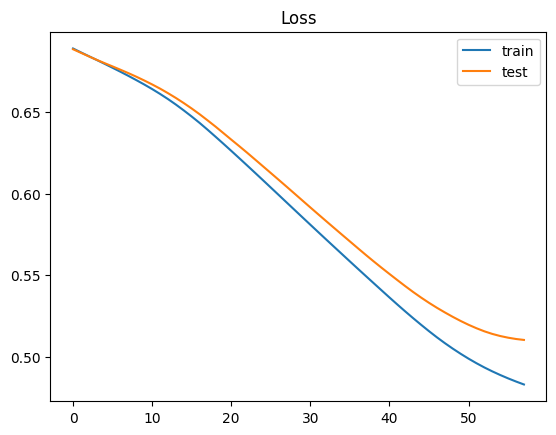

In [49]:
plotting(train_loss_history, test_loss_history, "Loss")

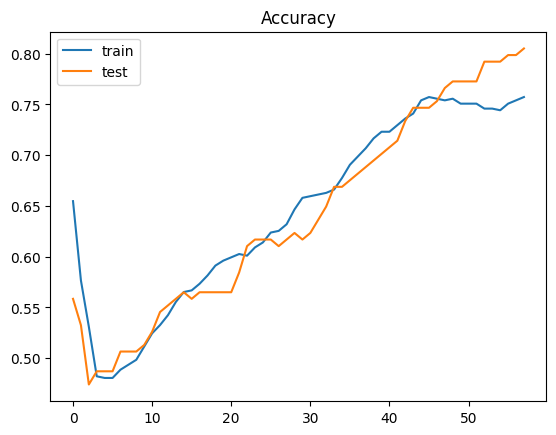

In [50]:
plotting(train_accuracy_history, test_accuracy_history, "Accuracy")